<a href="https://colab.research.google.com/github/JJang-likit/GoingDeeper_Aiffel/blob/main/GoingDeeper_ResNet_Ablation_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet Ablation Study

## 순서
- 데이터셋 준비
- ResNet 구성
- 모델 생성
- 모델 훈련
- 모델 학습 결과 확인 및 시각화
- 정리 및 회고

### 데이터셋 준비
- tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 사용한다.

In [1]:
# 사용할 라이브러리 준비하기

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()
tfds.disable_progress_bar()

In [2]:
# GPU 사용 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files = True,
    with_info = True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteF2VFNJ/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
# 다운받은 데이터셋 정보 확인

print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
# 데이터의 수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
# 데이터 정규화 함수 정의

# 각 채널별 최댓값인 255로 정규화

def normalize_and_resize_img(image, label):
  """Normalizes images : 'uint8' -> 'float32'."""
  image = tf.image.resize(image, [224, 224])
  return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=1
  )
  ds = ds.batch(batch_size)
  if not is_test:
      ds = ds.repeat()
      ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

### ResNet 구성하기

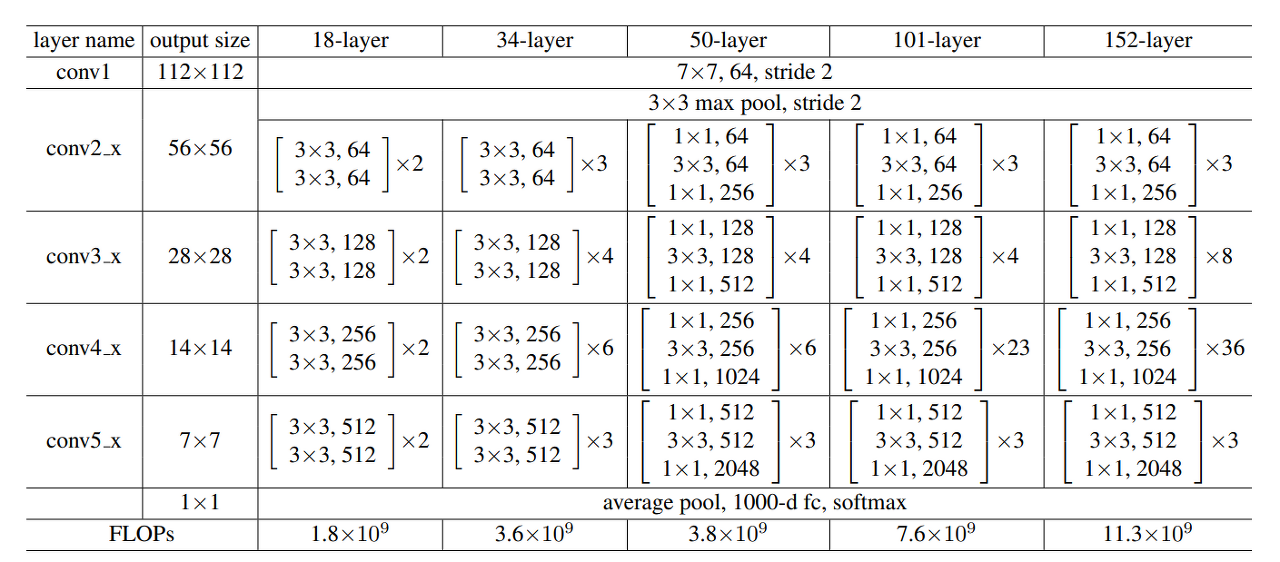

- ResNet 34를 기준으로 보면 블럭은 총 4개가 사용되었다.
- 블럭마다 사용되는 conv 필터의 개수는 각각 다르다.
- VGG처럼 모든 conv 필터 사이즈는 3x3으로 사용되고 있다.
- 위 자료에서는 보이지 않지만 conv를 통과하면 Batchnormalization을 사용한다.
- 한 블럭이 끝나면 MaxPooling을 사용하고 마지막 block가 끝나면 average pooling을 사용한다.

In [8]:
# ResNet block 생성 함수 만들기

def build_resnet_block(input_layer, num_cnn = 3, channel = 64, block_num = 1, is_50 = False, is_plain = False):
  x = input_layer
  if not is_50:
    for cnn_num in range(num_cnn):
      identity = x
      x = keras.layers.Conv2D(
          filters = channel,
          kernel_size = (3,3),
          activation = 'relu',
          kernel_initializer = 'he_normal',
          padding = 'same',
          name = f'block{block_num}_conv{cnn_num}'
      )(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Conv2D(
          filters = channel,
          kernel_size = (3,3),
          activation = 'relu',
          kernel_initializer = 'he_normal',
          padding = 'same',
          name = f'block{block_num}_1_conv{cnn_num}'
      )(x)
      if not is_plain:
        identity_channel = identity.shape.as_list()[-1]

        if identity_channel != channel:
          identity = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='same')(identity)

        # skip connection
        x = keras.layers.Add()([x, identity])
      
      else:
        pass
  else : 
    identity = x
    x = keras.layers.Conv2D(
        filters = channel,
        kernel_size = (1,1),
        activation = 'relu',
        kernel_initializer = 'he_normal',
        padding = 'same',
        name = f'block{block_num}_conv{cnn_num}'
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(
        filters = channel,
        kernel_size = (3,3),
        activation = 'relu',
        kernel_initializer = 'he_normal',
        padding = 'same',
        name = f'block{block_num}_1_conv{cnn_num}'
    )(x)
    x = keras.layers.Conv2D(
        filters = channel * 4,
        kernel_size = (1,1),
        activation = 'relu',
        kernel_initializer = 'he_normal',
        padding = 'same',
        name = f'block{block_num}_2_conv{cnn_num}'
    )(x)
    if not is_plain:
      identity_channel = identity.shape.as_list()[-1]

      if identity_channel != channel:
        identity = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='same')(identity)

      # skip connection
      x = keras.layers.Add()([x, identity])
    else:
      pass

  # Max Pooling 레이어
  # 마지막 블록 뒤에는 pooling 하지 않음

  if identity.shape[1] != 1:
    x = keras.layers.MaxPooling2D(
        pool_size = (2,2),
        strides = 2,
        name = f'block{block_num}_pooing'
    )(x)

  return x

In [9]:
# ResNet 모델 자체를 만드는 함수

def build_resnet(input_shape = (32,32,3),
                 num_cnn_list = [3,4,6,3],
                 channel_list = [64, 128, 256, 512],
                 num_classes = 10,
                 is_50 = False,
                 is_plain = False):
    # 모델을 만들기 전에 config list들이 같은 길이인지 확인한다.
    assert len(num_cnn_list) == len(channel_list)
    if is_50:
      num_cnn_list = [3,4,6,3]
      channel_list = [64,128,256,512]
      num_classes = 10

    input_layer = keras.layers.Input(shape = input_shape)
    output = input_layer

    # ResNet 34와 50의 공통된 앞 부분
    output = keras.layers.Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'same')(output)
    output = keras.layers.BatchNormalization()(output)

    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2)(output)

    # config list들의 길이만큼 반복해서 블록을 생성한다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
      output = build_resnet_block(
          output,
          num_cnn = num_cnn,
          channel = channel,
          block_num = i
      )
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name = 'flatten')(output)
    output = keras.layers.Dense(512, activation = 'relu', name = 'fc1')(output)
    output = keras.layers.Dense(num_classes, activation = 'softmax', name = 'predictions')(output)

    model = keras.Model(inputs = input_layer, outputs = output)

    return model


In [10]:
resnet_34 = build_resnet(input_shape = (32,32,3), is_50=False, is_plain=True)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['batch_normalization[0][0]']

In [11]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True, is_plain=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 16, 16, 64)  256         ['conv2d_4[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)    0           ['batch_normalization_17[0]

### 모델 훈련
- BATCH_SIZE, EPOCH를 설정해준다.

In [12]:
BATCH_SIZE = 32
EPOCH = 10

In [13]:
# 데이터 정규화

ds_train = apply_normalize_on_dataset(ds_train, batch_size = BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size = BATCH_SIZE)

In [14]:
# 모델 훈련 / ResNet-34 / not plain 모델

resnet_34 = build_resnet(input_shape = (224,224,3), is_50=False, is_plain=False)

resnet_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1),
    metrics = ['accuracy']
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 128s 181ms/step - loss: 1.4143 - accuracy: 0.5824 - val_loss: 1.6301 - val_accuracy: 0.5468
Epoch 2/10
581/581 [==============================] - 108s 186ms/step - loss: 0.8192 - accuracy: 0.6412 - val_loss: 1.1344 - val_accuracy: 0.5742
Epoch 3/10
581/581 [==============================] - 109s 187ms/step - loss: 0.6092 - accuracy: 0.6947 - val_loss: 0.7148 - val_accuracy: 0.6197
Epoch 4/10
581/581 [==============================] - 109s 187ms/step - loss: 0.5318 - accuracy: 0.7353 - val_loss: 0.5474 - val_accuracy: 0.7361
Epoch 5/10
581/581 [==============================] - 109s 187ms/step - loss: 0.4781 - accuracy: 0.7697 - val_loss: 0.7238 - val_accuracy: 0.6886
Epoch 6/10
581/581 [==============================] - 109s 187ms/step - loss: 0.4392 - accuracy: 0.7939 - val_loss: 0.8247 - val_accuracy: 0.7082
Epoch 7/10
581/581 [==============================] - 109s 187ms/step - loss: 0.3829 - accuracy: 0.8258 - val_loss: 0.8164 - val_accura

In [15]:
# 모델 훈련 / ResNet-50 / not plain 모델

resnet_50 = build_resnet(input_shape = (224,224,3), is_50=True, is_plain=False)

resnet_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1),
    metrics = ['accuracy']
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 119s 188ms/step - loss: 1.3380 - accuracy: 0.5934 - val_loss: 1.2096 - val_accuracy: 0.5818
Epoch 2/10
581/581 [==============================] - 109s 187ms/step - loss: 0.8130 - accuracy: 0.6393 - val_loss: 0.7284 - val_accuracy: 0.6422
Epoch 3/10
581/581 [==============================] - 109s 187ms/step - loss: 0.6011 - accuracy: 0.6981 - val_loss: 0.8706 - val_accuracy: 0.5996
Epoch 4/10
581/581 [==============================] - 109s 187ms/step - loss: 0.5325 - accuracy: 0.7372 - val_loss: 0.6258 - val_accuracy: 0.6972
Epoch 5/10
581/581 [==============================] - 109s 187ms/step - loss: 0.4787 - accuracy: 0.7716 - val_loss: 0.5731 - val_accuracy: 0.7183
Epoch 6/10
581/581 [==============================] - 109s 187ms/step - loss: 0.4310 - accuracy: 0.8008 - val_loss: 0.5876 - val_accuracy: 0.7254
Epoch 7/10
581/581 [==============================] - 109s 187ms/step - loss: 0.3858 - accuracy: 0.8265 - val_loss: 0.5119 - val_accura

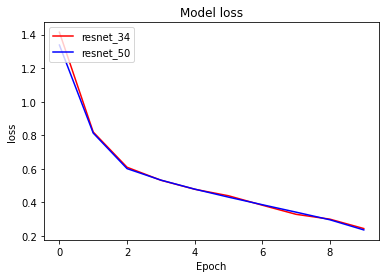

In [16]:
# loss 감소 비교

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

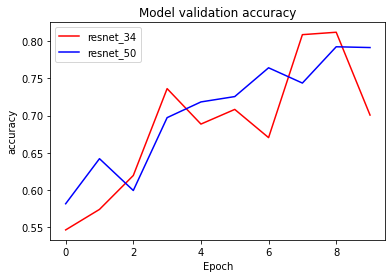

In [17]:
# 검증 정확도 비교

plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

In [18]:
# 모델 훈련 / ResNet-34 / plain 모델

resnet_34 = build_resnet(input_shape = (224,224,3), is_50=False, is_plain=True)

resnet_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1),
    metrics = ['accuracy']
)

history_34_plain = resnet_34.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 119s 188ms/step - loss: 1.3423 - accuracy: 0.5821 - val_loss: 1.2068 - val_accuracy: 0.5370
Epoch 2/10
581/581 [==============================] - 108s 187ms/step - loss: 0.7334 - accuracy: 0.6561 - val_loss: 0.6895 - val_accuracy: 0.6444
Epoch 3/10
581/581 [==============================] - 109s 187ms/step - loss: 0.5831 - accuracy: 0.7059 - val_loss: 0.6501 - val_accuracy: 0.6623
Epoch 4/10
581/581 [==============================] - 108s 187ms/step - loss: 0.5082 - accuracy: 0.7538 - val_loss: 3.5029 - val_accuracy: 0.6625
Epoch 5/10
581/581 [==============================] - 109s 187ms/step - loss: 0.4603 - accuracy: 0.7822 - val_loss: 0.6667 - val_accuracy: 0.6946
Epoch 6/10
581/581 [==============================] - 109s 187ms/step - loss: 0.4055 - accuracy: 0.8156 - val_loss: 0.5498 - val_accuracy: 0.7619
Epoch 7/10
581/581 [==============================] - 109s 187ms/step - loss: 0.3550 - accuracy: 0.8388 - val_loss: 0.6224 - val_accura

In [19]:
# 모델 훈련 / ResNet-34 / plain 모델

resnet_50 = build_resnet(input_shape = (224,224,3), is_50=True, is_plain=True)

resnet_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1),
    metrics = ['accuracy']
)

history_50_plain = resnet_50.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 120s 189ms/step - loss: 1.3053 - accuracy: 0.5849 - val_loss: 1.3224 - val_accuracy: 0.5379
Epoch 2/10
581/581 [==============================] - 109s 187ms/step - loss: 0.7508 - accuracy: 0.6462 - val_loss: 0.9416 - val_accuracy: 0.5672
Epoch 3/10
581/581 [==============================] - 109s 187ms/step - loss: 0.5793 - accuracy: 0.7060 - val_loss: 0.5864 - val_accuracy: 0.7153
Epoch 4/10
581/581 [==============================] - 109s 187ms/step - loss: 0.5225 - accuracy: 0.7444 - val_loss: 0.6268 - val_accuracy: 0.7022
Epoch 5/10
581/581 [==============================] - 109s 188ms/step - loss: 0.4797 - accuracy: 0.7715 - val_loss: 0.5540 - val_accuracy: 0.7465
Epoch 6/10
581/581 [==============================] - 109s 187ms/step - loss: 0.4305 - accuracy: 0.7983 - val_loss: 0.8031 - val_accuracy: 0.6721
Epoch 7/10
581/581 [==============================] - 109s 187ms/step - loss: 0.3821 - accuracy: 0.8289 - val_loss: 0.5391 - val_accura

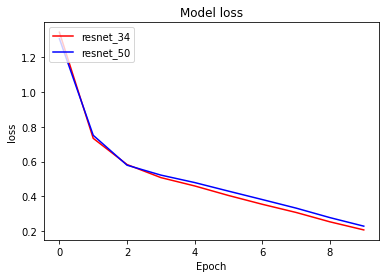

In [20]:
# loss 감소 비교

plt.plot(history_34_plain.history['loss'], 'r')
plt.plot(history_50_plain.history['loss'], 'b')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

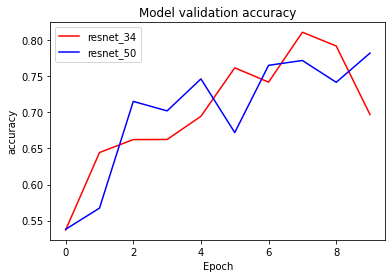

In [21]:
# 검증 정확도 비교

plt.plot(history_34_plain.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

In [25]:
pip install keras

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [36]:
res_model = ResNet50(include_top = True, weights = None, input_shape = (32,32,3), pooling = max, classes = 3)
res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [37]:
# 모델 훈련 

resnet_50_model = ResNet50(input_shape = (224,224,3))

resnet_50_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01, clipnorm=1),
    metrics = ['accuracy']
)

history_50_model = resnet_50_model.fit(
    ds_train,
    steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
)

102981632/102967424 [==============================] - 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 230s 369ms/step - loss: 0.4705 - accuracy: 0.9211 - val_loss: 0.8208 - val_accuracy: 0.7000
Epoch 2/10
581/581 [==============================] - 211s 364ms/step - loss: 0.0224 - accuracy: 0.9934 - val_loss: 0.0450 - val_accuracy: 0.9849
Epoch 3/10
581/581 [==============================] - 211s 363ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0375 - val_accuracy: 0.9892
Epoch 4/10
581/581 [==============================] - 211s 364ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0321 - val_accuracy: 0.9900
Epoch 5/10
581/581 [==============================] - 211s 363ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0370 - val_accuracy: 0.9909
Epoch 6/10
581/581 [==============================] - 212s 364ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0342 - val_accuracy: 0.9899
Epoch 7/10
581/581 [==============================] - 212s 364ms/step - loss: 6.7629e-04 - accuracy: 0.9999 - val_loss: 0.0374 - val_ac

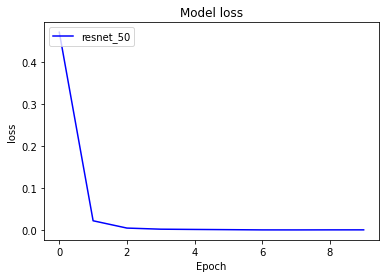

In [39]:
# loss 감소 비교


plt.plot(history_50_model.history['loss'], 'b')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50'], loc='upper left')
plt.show()

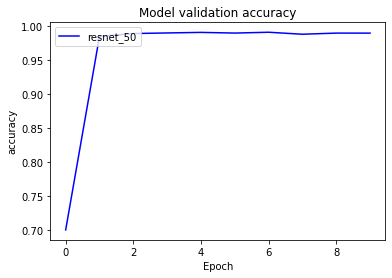

In [40]:
# 검증 정확도 비교

plt.plot(history_50_model.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50'], loc='upper left')
plt.show()

## 정리 및 회고

### 결과 정리

- ResNet-34 와 50을 직접 만들었을 때 노드에서 제시한 결과랑은 약간의 차이가 있었다.
- 노드에서 제시한 모델의 params와는 조금 차이가 있었다.
- 아마 블록함수 구성에서 노드 작성자가 생각한 블록함수 구성과 조금 달랐던 것 같다.

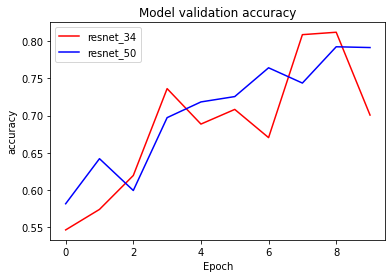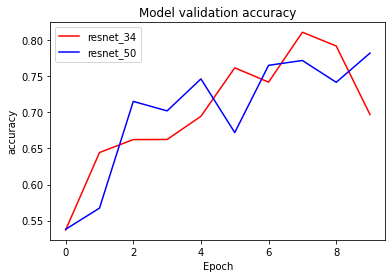

- 위의 결과 그래프에서 좌측이 plain 모델이고 우측이 residual 모델이다.
- loss측면에서는 두 모델 모두 안정적인 감소를 보여주었지만 정확도 측면에서는 들쭉날쭉한 모습이다.
- 그렇기 때문에 두 모델 모두 좋은 결과를 보여주었다고는 할 수 없을 것 같다.
- 블록함수 구성의 차이때문이라면 어떻게 블록함수를 구성하는게 표준적인 방법인지는 사람마다 기준이 다르기 때문에 어느 방법이 정답이라고 생각할만한 코드는 잘 모르겠다.
- 구글링을 통해서 ResNet에 대해서 검색해보면 정말 다양한 사람들이 다양한 방법으로 ResNet을 연구하고 만든 것을 확인할 수 있고 다양한 라이브러리에 따라서 ResNet 구성 방식도 조금씩 다른 것 같다.

- 개인적으로 궁금해서 케라스에서 지원하는 ResNet의 성능은 어떤지 테스트해보기로 했다.
- ResNet-50을 불러와서 같은 데이터셋을 이용해서 모델을 돌려보았다.

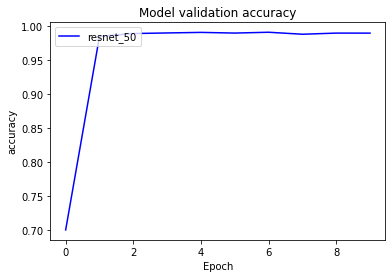

- 결과는 내가 직접 구성한 모델보다 훨씬 좋은 것 같다.
- 데이터셋이 크지 않기 때문에 정확한 성능을 측정하기는 어렵겠지만 내가 직접 구성한 모델보다는 안정적인 성능이라고 생각한다.

### 회고
- 첫 GoingDeeper 노드를 진행하면서 예전 Fundamental때보다 더 난이도가 높아진 것을 체감할 수 있었다.
- 특히 논문을 읽고 논문 내용을 바탕으로 이해하고 학습을 진행해야 하는데 논문 내용도 어렵고 논문이 영어로 되어있기 때문에 시간이 꽤 많이 걸린다.
- 물론 구글이나 유튜브에 논문에 대한 설명과 그것을 응용한 학습 내용들이 많이 있어서 큰 도움이 된 것 같다.
- 확실히 예전처럼 앞에서 제시한 코드들을 복사해서 학습을 진행했을때보다 직접 코드를 찾아보고 코드를 작성해보는 활동을 하니까 더 재미있었던 것 같다.
- 어렵지만 공부한 내용에 대해서 깊이 생각하고 좀 더 깊게 이해할 수 있게 된 것 같다.